In [ ]:
# 1 basic model I used data augmentation to reduce overfitting!

import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import tensorflow.keras as keras
tf.__version__

'2.18.0'

In [ ]:
import os
import zipfile

local_zip = '/tmp/image_scene.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/image_scene')
zip_ref.close()

In [ ]:
base_dir = '/tmp/image_scene'

#train directories
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

In [ ]:
import shutil

# create directories for partial train and test data images/category)

categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
num_images = 350
partial_train_dir = '/tmp/partial_train'
partial_test_dir = '/tmp/partial_test'

os.makedirs(partial_train_dir, exist_ok=True)
os.makedirs(partial_test_dir, exist_ok=True)

In [ ]:
# copy images from each category to 'partial...' directives
def reduce_data(input_dir, output_dir):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    image_files = os.listdir(category_dir)[:num_images]
    for image_file in image_files:
      source_path = os.path.join(category_dir, image_file)
      dst_path = os.path.join(output_category_dir, image_file)
      shutil.copy(source_path, dst_path)

reduce_data(train_dir, partial_train_dir)
reduce_data(test_dir, partial_test_dir)

In [ ]:
# initilaizing training arrays
train_images = []
train_labels = []

In [ ]:
import numpy as np

# only for training data
# combine all subpaths to one
# so that later we can use flow_from_dataframe
def combining_paths(input_dir, features_array, labels_array):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    for fname in os.listdir(category_dir):
      features_array.append(os.path.join(category_dir, fname))
      labels_array.append(category)

combining_paths(partial_train_dir, train_images, train_labels)

# will use flow from directory for test data

In [ ]:
# convert all training arrays to numpy arrays (dataframe) of images
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
model = 0

#baseline network

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      37,880,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,974,854 (144.86 MB)

 Trainable params: 37,974,854 (144.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#data augmentation

# augment train data to reduce overfitting
train_augment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# do not augment val and test data!
val_augment = ImageDataGenerator(rescale=1./255)
test_augment = ImageDataGenerator(rescale=1./255)

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from sklearn.model_selection import KFold
import pandas as pd

k=4
kf = KFold(n_splits=k, shuffle=True, random_state=42)
all_scores=[]
num_epochs = 30
batch_size = 35

train_acc = []
val_acc =  []
train_loss = []
val_loss = []

In [ ]:
test_generator = test_augment.flow_from_directory(
    partial_test_dir,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2081 images belonging to 6 classes.


In [ ]:
history = None #manually resets history everytime when running cell

for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):
  print(f'\nProcessing fold # {fold+1}/{k} ###########################')

  #split train_images dataframe into train and val
  train_x, val_x = train_images[train_idx], train_images[val_idx]
  train_y, val_y = train_labels[train_idx], train_labels[val_idx]

  # train generator use flow from dataframe
  train_generator = train_augment.flow_from_dataframe(
    dataframe = pd.DataFrame({'filename': train_x, 'class': train_y}),
    x_col = 'filename',
    y_col = 'class',
    target_size = (150,150),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=True)

  # val generator use flow from dataframe
  val_generator = val_augment.flow_from_dataframe(
      dataframe = pd.DataFrame({'filename': val_x, 'class': val_y}),
      x_col = 'filename',
      y_col = 'class',
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle = True
  )

  history = model.fit(
      train_generator,
      steps_per_epoch=80, #2100 images = batch size * steps (60)
      epochs=num_epochs,
      validation_data=val_generator,
      validation_steps = 80)

  train_acc.append(history.history['acc'])
  val_acc.append(history.history['val_acc'])
  train_loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



Processing fold # 1/4 ###########################
Found 1575 validated image filenames belonging to 6 classes.
Found 525 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - acc: 0.2650 - loss: 1.7374

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - acc: 0.3035 - loss: 1.6671 - val_acc: 0.5162 - val_loss: 1.1957
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - acc: 0.4953 - loss: 1.2753 - val_acc: 0.5390 - val_loss: 1.1292
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - acc: 0.5572 - loss: 1.1498 - val_acc: 0.5524 - val_loss: 1.1057
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - acc: 0.5472 - loss: 1.1141 - val_acc: 0.5962 - val_loss: 1.0177
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - acc: 0.5962 - loss: 1.0520 - val_acc: 0.6095 - val_loss: 0.9743
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - acc: 0.5907 - loss: 1.0415 - val_acc: 0.6457 - val_loss: 0.9164
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - acc: 0.6138 - loss: 1.0396 - val_acc: 0.6533 - val_loss: 0.9330
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - acc: 0.6043 - loss: 1.0151 - val_acc: 0.6552 - val_loss: 0.8822
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - acc:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - acc: 0.7096 - loss: 0.7939

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 0.7072 - loss: 0.7952 - val_acc: 0.7752 - val_loss: 0.5980
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - acc: 0.7010 - loss: 0.8010 - val_acc: 0.7162 - val_loss: 0.7293
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 0.7235 - loss: 0.7649 - val_acc: 0.7543 - val_loss: 0.6122
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - acc: 0.7262 - loss: 0.7438 - val_acc: 0.7524 - val_loss: 0.6329
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 0.7271 - loss: 0.7468 - val_acc: 0.7276 - val_loss: 0.6536
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - acc: 0.7212 - loss: 0.7322 - val_acc: 0.7086 - val_loss: 0.7411
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - acc: 0.7373 - loss: 0.7457 - val_acc: 0.7810 - val_loss: 0.5980
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 0.7334 - loss: 0.7210 - val_acc: 0.7505 - val_loss: 0.6572
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - acc:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - acc: 0.7652 - loss: 0.6686

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - acc: 0.7604 - loss: 0.6631 - val_acc: 0.8343 - val_loss: 0.5098
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc: 0.7459 - loss: 0.6753 - val_acc: 0.7810 - val_loss: 0.6369
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - acc: 0.7448 - loss: 0.6517 - val_acc: 0.7886 - val_loss: 0.5546
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - acc: 0.7653 - loss: 0.6266 - val_acc: 0.7505 - val_loss: 0.6430
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 0.7685 - loss: 0.6270 - val_acc: 0.7981 - val_loss: 0.5428
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 0.7720 - loss: 0.5918 - val_acc: 0.8000 - val_loss: 0.5304
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 0.7770 - loss: 0.6052 - val_acc: 0.7695 - val_loss: 0.6437
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 0.7772 - loss: 0.6111 - val_acc: 0.7676 - val_loss: 0.6019
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - acc:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - acc: 0.7951 - loss: 0.5575

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 0.7920 - loss: 0.5604 - val_acc: 0.8419 - val_loss: 0.4569
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - acc: 0.7803 - loss: 0.5522 - val_acc: 0.8533 - val_loss: 0.4057
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - acc: 0.8077 - loss: 0.5167 - val_acc: 0.8019 - val_loss: 0.5386
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - acc: 0.8044 - loss: 0.5315 - val_acc: 0.8152 - val_loss: 0.5849
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc: 0.7842 - loss: 0.5202 - val_acc: 0.8267 - val_loss: 0.4885
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - acc: 0.8058 - loss: 0.5510 - val_acc: 0.7810 - val_loss: 0.6269
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - acc: 0.7853 - loss: 0.5614 - val_acc: 0.8210 - val_loss: 0.5050
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - acc: 0.8137 - loss: 0.5096 - val_acc: 0.8362 - val_loss: 0.5071
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - acc:

In [ ]:
model.save('image_scene_basic.h5')

In [ ]:
model.evaluate(test_generator, verbose=1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - acc: 0.7683 - loss: 0.6951


[0.691550612449646, 0.7703027129173279]

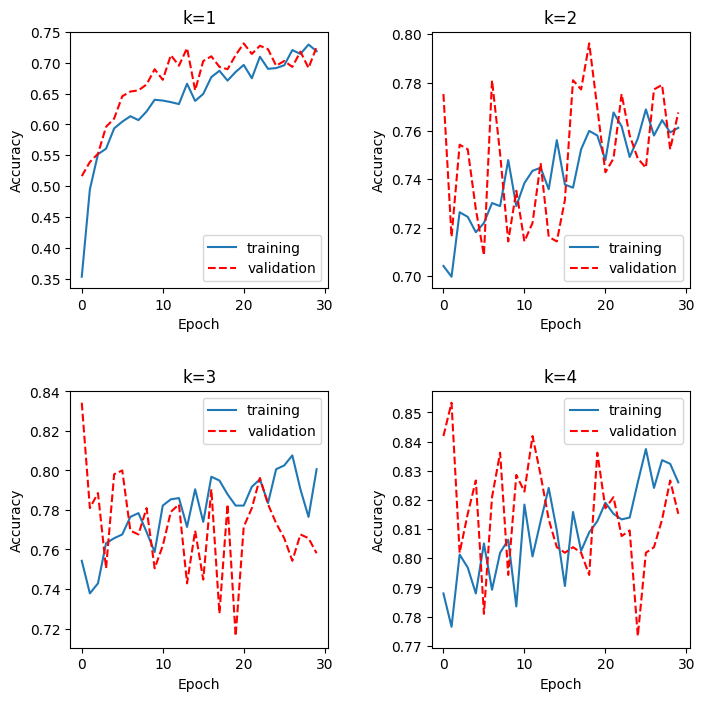

In [ ]:
import matplotlib.pyplot as plt

# Cross fold 0
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0, 0].plot(np.arange(num_epochs), train_acc[0], label='training')
axs[0, 0].plot(np.arange(num_epochs), val_acc[0], 'r--', label='validation')
axs[0, 0].set_title("k=1")
axs[0, 0].set(xlabel='Epoch', ylabel='Accuracy')
axs[0, 0].legend()

# Cross fold 1
axs[0, 1].plot(np.arange(num_epochs), train_acc[1], label='training')
axs[0, 1].plot(np.arange(num_epochs), val_acc[1], 'r--', label='validation')
axs[0, 1].set_title("k=2")
axs[0, 1].set(xlabel='Epoch', ylabel='Accuracy')
axs[0, 1].legend()

# Cross fold 2
axs[1, 0].plot(np.arange(num_epochs), train_acc[2], label='training')
axs[1, 0].plot(np.arange(num_epochs), val_acc[2], 'r--', label='validation')
axs[1, 0].set_title("k=3")
axs[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
axs[1, 0].legend()

# Cross fold 3
axs[1, 1].plot(np.arange(num_epochs), train_acc[3], label='training')
axs[1, 1].plot(np.arange(num_epochs), val_acc[3], 'r--', label='validation')
axs[1, 1].set_title("k=4")
axs[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1, 1].legend()
plt.show()
